In [1]:
import glob
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set(style="whitegrid", palette="muted")

from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Pool

from tqdm import tqdm

In [2]:
!mkdir -p plots

In [3]:
results_dir = "results/sigmod/1649927869/1649927869"
result_name = "10000-rr-32"

In [4]:
forecast_files = glob.glob(f"{results_dir}/forecast.*.jsonl")

key_to_timestamps = defaultdict(list)
key_to_last_seqnos = defaultdict(list)
key_to_last_seqno_to_forecast = defaultdict(dict)
path_to_key_set = dict()


def _process_file(path):
    key_to_timestamps = defaultdict(list)
    key_to_last_seqnos = defaultdict(list)
    key_to_last_seqno_to_forecast = defaultdict(dict)

    key_set = set()
    with open(path) as f:
        for line in f:
            loaded = json.loads(line)
            key_id = str(loaded["key_id"])
            key_set.add(key_id)
            key_to_timestamps[key_id].append(loaded["processing_time"])
            key_to_last_seqnos[key_id].append(loaded["last_seqno"])
            key_to_last_seqno_to_forecast[key_id][loaded["last_seqno"]] = loaded[
                "forecast"
            ]
    return (
        key_to_timestamps,
        key_to_last_seqnos,
        key_to_last_seqno_to_forecast,
        {path: list(key_set)},
    )


with Pool() as p:
    results = list(
        tqdm(p.imap(_process_file, forecast_files), total=len(forecast_files))
    )
    for r in results:
        (
            key_to_timestamps_shard,
            key_to_last_seqnos_shard,
            key_to_last_seqno_to_forecast_shard,
            path_to_key_set_shard,
        ) = r
        key_to_timestamps.update(key_to_timestamps_shard)
        key_to_last_seqnos.update(key_to_last_seqnos_shard)
        key_to_last_seqno_to_forecast.update(key_to_last_seqno_to_forecast_shard)
        path_to_key_set.update(path_to_key_set_shard)

100%|██████████████████████████████████████████████████████████████████████████| 32/32 [03:20<00:00,  6.26s/it]


In [5]:
source_files = glob.glob(f"{results_dir}/source.*.jsonl")
key_to_source_series = defaultdict(list)
key_to_source_timestamps = defaultdict(list)
key_to_source_seqno = defaultdict(list)
for path in source_files:
    with open(path) as f:
        for line in tqdm(f, total=8639):
            loaded = json.loads(line)
            for entry in loaded:
                key_id = str(entry["key_id"])
                key_to_source_series[key_id].append(entry["value"])
                key_to_source_timestamps[key_id].append(entry["ingest_time"])
                key_to_source_seqno[key_id].append(entry["seq_no"])

100%|██████████████████████████████████████████████████████████████████████| 8639/8639 [02:39<00:00, 54.25it/s]


In [6]:
key_df_data = []
shard_idx = 0
for k, v in path_to_key_set.items():
    key_df_data.extend([{"shard_idx": shard_idx, "key": key} for key in v])
    shard_idx += 1
key_df = pd.DataFrame(key_df_data)

In [8]:
num_forecasts = pd.DataFrame(
    [{"key": k, "num_forecasts": len(v)} for k, v in key_to_last_seqnos.items()]
)
num_forecasts.describe()

,num_forecasts
count,10000.000000
mean,20.083700
std,9.450345
min,1.000000
25%,12.000000
50%,26.000000
75%,27.000000
max,27.000000


In [13]:
num_forecasts = num_forecasts.merge(
    key_df
)  # .groupby("shard_idx")["num_forecasts"].sum().plot()

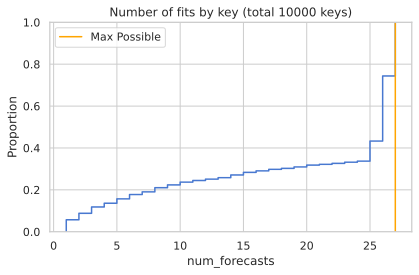

In [7]:
sns.ecdfplot(num_forecasts["num_forecasts"])
plt.title(f"Number of fits by key (total {len(num_forecasts)} keys)")
plt.axvline(27, color="orange", label="Max Possible")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/{result_name}-nfits.pdf", dpi=300)

In [14]:
num_forecasts.to_csv(f"plots/{result_name}-nfits.csv", index=None)

In [15]:
f"plots/{result_name}-nfits.csv"

'plots/10000-rr-32-nfits.csv'

In [9]:
def compute_key(key):
    cached_path = f"{results_dir}/key_{key}_{result_name}.pq"
    if not os.path.exists(cached_path):
        pred_df = (
            pd.DataFrame(
                {
                    "timestamp": key_to_timestamps[key],
                    "last_seqno": key_to_last_seqnos[key],
                }
            )
            .sort_values("timestamp")
            .set_index("timestamp")
        )
        true_df = (
            pd.DataFrame(
                {
                    "timestamp": key_to_source_timestamps[key],
                    "avg_cpu": key_to_source_series[key],
                    "seq_no": key_to_source_seqno[key],
                }
            )
            .sort_values("timestamp")
            .set_index("timestamp")
        )

        merged = pd.merge_asof(
            left=true_df, right=pred_df, on="timestamp", direction="backward"
        )

        forecast = key_to_last_seqno_to_forecast[key]
        frame = pd.DataFrame(forecast)
        frame = (
            frame.T.reset_index()
            .melt("index")
            .rename(columns={"variable": "seq_delta", "index": "last_seqno"})
        )

        m = merged.dropna().reset_index(drop=True)
        m.loc[:, "seq_delta"] = (m["seq_no"] - m["last_seqno"]).astype(int)
        final = m.merge(frame, how="left", on=["last_seqno", "seq_delta"])
        final.to_parquet(cached_path)
    else:
        final = pd.read_parquet(cached_path)

    # mse_per_key_per_s = final.groupby(final["timestamp"].astype(int)).apply(
    #     lambda d: pd.Series(
    #         {"mse": ((d["avg_cpu"] - d["value"]) ** 2).mean(), "count": len(d)}
    #     )
    # )

    diff = (final["avg_cpu"] - final["value"]) ** 2
    count_column = diff.groupby(final["timestamp"].astype(int)).count()
    mse_column = diff.groupby(final["timestamp"].astype(int)).mean()
    mse_per_key_per_s = pd.DataFrame({"mse": mse_column, "count": count_column})

    mse_per_key_per_s["key"] = key
    return mse_per_key_per_s


with Pool(90) as p:
    mses = list(
        tqdm(
            p.imap(compute_key, key_to_timestamps.keys()), total=len(key_to_timestamps)
        )
    )

100%|████████████████████████████████████████████████████████████████████| 10000/10000 [02:39<00:00, 62.62it/s]


In [10]:
# we are dropping some keys here :sigh:
# need to figure out how to handle a key that's never fitted
# final length 4965 for 5000
all_mse = pd.concat([f.reset_index() for f in mses if len(f)])

In [11]:
all_mse.to_parquet(f"plots/{result_name}-all_mse.pq", index=None)

In [12]:
mse_by_timestamp = all_mse.groupby("timestamp").apply(
    lambda d: (d["mse"] * d["count"]).sum() / (d["count"].sum())
)

In [13]:
mse_by_timestamp.index = mse_by_timestamp.index - mse_by_timestamp.index.min()

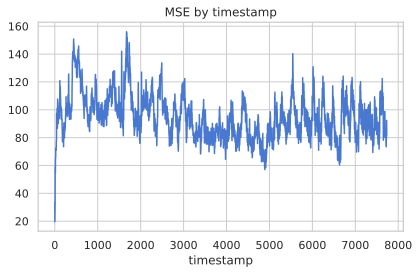

In [14]:
mse_by_timestamp.plot()
plt.title("MSE by timestamp")
plt.tight_layout()
plt.savefig(f"plots/{result_name}-mse-time.pdf", dpi=300)
mse_by_timestamp.to_csv(f"plots/{result_name}-mse-time.csv", index=True)